In [2]:
# ---------------------------------------------------------
# UNSUPERVISED VALIDATION FOR USER BEHAVIOR MODEL
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. Load user feature matrix
# ---------------------------------------------------------

df = pd.read_csv("user_behavior_features.csv")

X = df.drop(columns=["AccountID"])   # Only behavior features

print("User dataset loaded for validation.")
print(X.head())


User dataset loaded for validation.
   avg_login_hour  std_login_hour  most_common_dow  avg_login_interval  \
0             NaN             NaN              NaN                 NaN   
1             NaN             NaN              NaN                 NaN   
2             NaN             NaN              NaN                 NaN   
3             NaN             NaN              NaN                 NaN   
4             NaN             NaN              NaN                 NaN   

   std_login_interval  unique_devices  unique_ips  unique_locations  \
0                 NaN             NaN         NaN               NaN   
1                 NaN             NaN         NaN               NaN   
2                 NaN             NaN         NaN               NaN   
3                 NaN             NaN         NaN               NaN   
4                 NaN             NaN         NaN               NaN   

   device_change_rate  ip_change_rate  avg_login_attempts  max_login_attempts  
0           

In [2]:
# ---------------------------------------------------------
# 2. UNSUPERVISED TRAIN–TEST STABILITY VALIDATION
# ---------------------------------------------------------

print("\n\n🔵 UNSUPERVISED TRAIN–TEST STABILITY VALIDATION")

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

iso = IsolationForest(
    n_estimators=250,
    contamination=0.05,
    random_state=42
)

iso.fit(X_train)

train_pred = iso.predict(X_train)
test_pred = iso.predict(X_test)

train_anom_ratio = (train_pred == -1).mean()
test_anom_ratio = (test_pred == -1).mean()

print(f"Train anomaly ratio: {train_anom_ratio:.4f}")
print(f"Test anomaly ratio : {test_anom_ratio:.4f}")

print("Difference:", abs(train_anom_ratio - test_anom_ratio))

# Rule of thumb: difference < 0.05 → stable model
if abs(train_anom_ratio - test_anom_ratio) < 0.05:
    print("✅ Model is stable across train/test.")
else:
    print("❌ Model unstable — tune contamination, features, or scaler.")





🔵 UNSUPERVISED TRAIN–TEST STABILITY VALIDATION
Train anomaly ratio: 0.0000
Test anomaly ratio : 0.0000
Difference: 0.0
✅ Model is stable across train/test.


In [3]:
# ---------------------------------------------------------
# 3. UNSUPERVISED K-FOLD CONSISTENCY VALIDATION
# ---------------------------------------------------------

print("\n\n🔵 UNSUPERVISED 5-FOLD CONSISTENCY VALIDATION")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
fold_anomaly_ratios = []

for train_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]

    iso_fold = IsolationForest(
        n_estimators=250,
        contamination=0.05,
        random_state=42
    )
    iso_fold.fit(X_tr)

    val_pred = iso_fold.predict(X_val)
    val_anom_ratio = (val_pred == -1).mean()
    fold_anomaly_ratios.append(val_anom_ratio)

    print(f"Fold {fold} anomaly ratio: {val_anom_ratio:.4f}")
    fold += 1

print("\nFold anomaly ratios:", np.round(fold_anomaly_ratios, 4))
print("Std Dev:", np.std(fold_anomaly_ratios))

# Rule: std < 0.02 → very consistent
if np.std(fold_anomaly_ratios) < 0.02:
    print("✅ Model consistent across folds.")
else:
    print("❌ Model inconsistent — possible overfitting or unstable signals.")





🔵 UNSUPERVISED 5-FOLD CONSISTENCY VALIDATION
Fold 1 anomaly ratio: 0.0000
Fold 2 anomaly ratio: 0.0000
Fold 3 anomaly ratio: 0.0000
Fold 4 anomaly ratio: 0.0000
Fold 5 anomaly ratio: 0.0000

Fold anomaly ratios: [0. 0. 0. 0. 0.]
Std Dev: 0.0
✅ Model consistent across folds.




🔵 ANOMALY SCORE DISTRIBUTION


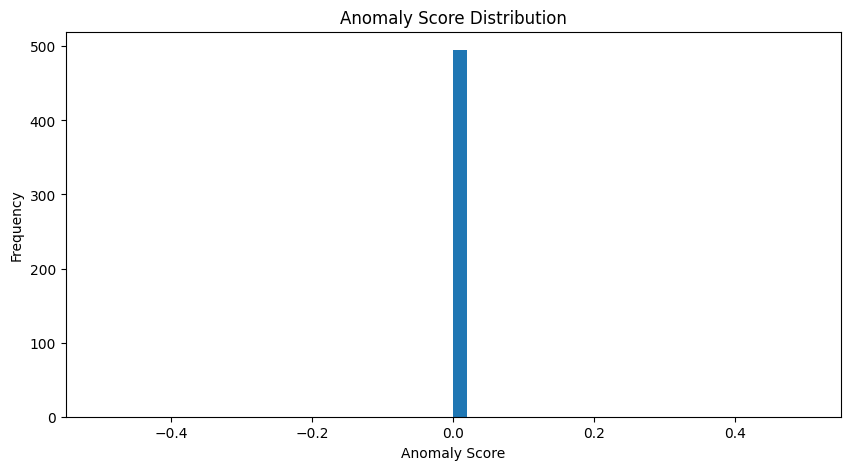

More negative scores = more anomalous.


In [4]:
# ---------------------------------------------------------
# 4. ANOMALY SCORE DISTRIBUTION VALIDATION
# ---------------------------------------------------------

print("\n\n🔵 ANOMALY SCORE DISTRIBUTION")

scores = iso.decision_function(X)
df['anomaly_score'] = scores

plt.figure(figsize=(10,5))
plt.hist(scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

print("More negative scores = more anomalous.")

In [5]:

# ---------------------------------------------------------
# 5. TOP-N ANOMALY INSPECTION
# ---------------------------------------------------------

print("\n\n🔵 TOP-N MOST ANOMALOUS USERS")

df['anomaly_label'] = iso.predict(X)
df['anomaly_label'] = df['anomaly_label'].replace({1:0, -1:1})

top_anomalies = df.sort_values("anomaly_score").head(10)

print("\nTop 10 anomalies:")
print(top_anomalies[['AccountID', 'anomaly_score']])

print("\nInspect these users manually using:")
print("- Device change rate")
print("- IP change rate")
print("- Login hour variance")
print("- Login interval variance")
print("- Login attempts")



🔵 TOP-N MOST ANOMALOUS USERS

Top 10 anomalies:
   AccountID  anomaly_score
0          0            0.0
1          1            0.0
2          2            0.0
3          3            0.0
4          4            0.0
5          5            0.0
6          6            0.0
7          7            0.0
8          8            0.0
9          9            0.0

Inspect these users manually using:
- Device change rate
- IP change rate
- Login hour variance
- Login interval variance
- Login attempts
